In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -q -U git+https://github.com/sbrugman/SDGym.git@v0.2.2-hw

In [ ]:
!pip install -q -U ../../

In [2]:
from timeit import default_timer as timer
from functools import partial
from random import choices
import logging

In [3]:
import sdgym
from sdgym import load_dataset
from sdgym import benchmark
from sdgym import load_dataset

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [5]:
import pgmpy

from pgmpy.models import BayesianModel
from pgmpy.estimators import TreeSearch, HillClimbSearch, BicScore, ExhaustiveSearch, BayesianEstimator
from pgmpy.sampling import BayesianModelSampling

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression

In [8]:
from sklearn.metrics import (
    mutual_info_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
)

In [9]:
from scipy import interpolate

In [10]:
from phik.phik import phik_from_binned_array

In [11]:
from synthsonic.models.kde_utils import kde_smooth_peaks_1dim, kde_smooth_peaks
from synthsonic.models.kde_copula_nn_pdf import KDECopulaNNPdf

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
logging.basicConfig(level=logging.INFO)

In [14]:
dataset_name = 'alarm'

In [15]:
data, categorical_columns, ordinal_columns = load_dataset(dataset_name)

INFO:sdgym.data:Loading dataset alarm (all variables)


In [16]:
data.shape

(10000, 37)

In [17]:
categorical_columns, ordinal_columns

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36],
 [])

In [18]:
for i in range(data.shape[1]):
    print (i, len(np.unique(data[:, i])))

0 2
1 3
2 3
3 2
4 3
5 2
6 3
7 2
8 3
9 3
10 2
11 3
12 2
13 2
14 3
15 4
16 2
17 4
18 2
19 3
20 3
21 3
22 2
23 2
24 3
25 4
26 2
27 3
28 4
29 4
30 4
31 4
32 3
33 2
34 3
35 3
36 3


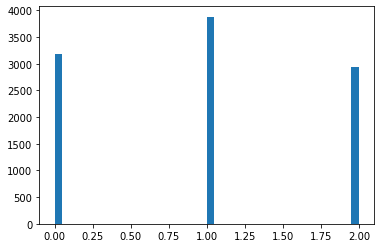

In [20]:
plt.hist(data[:, 14], bins=40);

# run sdgym

In [39]:
def KDECopulaNNPdf_Synthesizer(real_data, categorical_columns, ordinal_columns):
    all_features = list(range(real_data.shape[1]))
    numerical_features = list(set(all_features) - set(categorical_columns + ordinal_columns))
    data = np.float64(real_data)
    
    n_samples = data.shape[0]
    n_features = data.shape[1]
    
    clf = xgb.XGBClassifier(
        n_estimators=250,
        reg_lambda=1,
        gamma=0,
        max_depth=2
    )
#     clf = MLPClassifier(alpha=0.1, random_state=0, max_iter=1000, early_stopping=True)
    
    kde = KDECopulaNNPdf(
        use_KDE=False, 
        categorical_columns=categorical_columns+ordinal_columns,
        distinct_threshold=-1,
        n_uniform_bins=30,
        n_calibration_bins=100,
        test_size=0.3,
#        edge_weights_fn=phik_from_binned_array # normalized_mutual_info_score
#        clf=clf,
#         ordering='mi',
    )
    kde = kde.fit(data)
    
#     X_gen, sample_weight = kde.sample(n_samples)
    X_gen = kde.sample_no_weights(n_samples, show_progress=True)
    
    X_gen[:, categorical_columns+ordinal_columns] = np.round(X_gen[:, categorical_columns+ordinal_columns])
    X_gen = np.float32(X_gen)
    
    print(X_gen[:, :5])

    return X_gen

In [40]:
def KDECopulaNNPdf_SynthesizerInteger(real_data, categorical_columns, ordinal_columns):
    """Census has integer only..."""
    data = KDECopulaNNPdf_Synthesizer(real_data, categorical_columns, ordinal_columns)
    data = np.round(data)
    
    print(data[:, :5])

    return data

In [41]:
from sdgym.synthesizers import (
    CLBNSynthesizer, CTGANSynthesizer, IdentitySynthesizer, IndependentSynthesizer,
    MedganSynthesizer, PrivBNSynthesizer, TableganSynthesizer, TVAESynthesizer,
    UniformSynthesizer, VEEGANSynthesizer)

all_synthesizers = [
    #IdentitySynthesizer,
    #IndependentSynthesizer,
    #KDECopulaNNPdf_Synthesizer,
    KDECopulaNNPdf_SynthesizerInteger,
]

In [42]:
scores = sdgym.run(synthesizers=all_synthesizers, datasets=[dataset_name], iterations=1)

INFO:sdgym.benchmark:0%|          | 0/1 [00:00<?, ?it/s]
INFO:sdgym.benchmark:Evaluating KDECopulaNNPdf_SynthesizerInteger on dataset alarm; iteration 0; 359.53 MB
INFO:sdgym.data:Loading dataset alarm (all variables)
INFO:sdgym.benchmark:Running KDECopulaNNPdf_SynthesizerInteger on dataset alarm; iteration 0; 359.83 MB
INFO:KDECopulaNNPdf:Processing 0 numerical and 37 categorical columns
INFO:KDECopulaNNPdf:Transforming numerical variables.
INFO:KDECopulaNNPdf:Configuring Bayesian Network (cat+num).

  0%|          | 0/630.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/630.0 [00:00<?, ?it/s]
Building tree:  11%|█▏        | 72/630.0 [00:00<00:00, 610.05it/s]
Building tree:  21%|██▏       | 134/630.0 [00:00<00:00, 585.06it/s]
Building tree:  32%|███▏      | 204/630.0 [00:00<00:00, 603.42it/s]
Building tree:  42%|████▏     | 265/630.0 [00:00<00:00, 597.96it/s]
Building tree:  53%|█████▎    | 336/630.0 [00:00<00:00, 608.29it/s]
Building tree:  63%|██████▎   | 397/630.0 [00:00<00:00,

Generating for node: 2: 100%|██████████| 37/37 [00:05<00:00,  6.22it/s]
INFO:sdgym.benchmark:Scoring KDECopulaNNPdf_SynthesizerInteger on dataset alarm; iteration 0; 490.68 MB
INFO:sdgym.evaluate:Evaluating using Bayesian Likelihood.


[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0.]
 ...
 [1. 1. 1. 0. 1.]
 [1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0.]
 ...
 [1. 1. 1. 0. 1.]
 [1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


INFO:sdgym.benchmark:Finished KDECopulaNNPdf_SynthesizerInteger on dataset alarm; iteration 0; 386.57 MB
INFO:sdgym.benchmark:100%|##########| 1/1 [00:28<00:00, 28.42s/it]


In [43]:
scores

,alarm/syn_likelihood,alarm/test_likelihood,timestamp
VEEGANSynthesizer,-18.386073,-18.210907,2020-04-12 09:41:35.096775
CLBNSynthesizer,-12.458848,-11.187805,2020-10-17 09:46:54.494331
CTGAN,-15.882041,-13.097559,2020-10-17 09:46:54.494331
CTGANSynthesizer,-15.220448,-12.928010,2020-10-17 09:46:54.494331
CopulaGAN,-15.688131,-13.052851,2020-10-17 09:46:54.494331
GaussianCopulaCategorical,-12.906379,-15.574882,2020-10-17 09:46:54.494331
GaussianCopulaCategoricalFuzzy,-14.521543,-14.565064,2020-10-17 09:46:54.494331
GaussianCopulaOneHot,-15.476064,-15.666336,2020-10-17 09:46:54.494331
IdentitySynthesizer,-10.231837,-10.300455,2020-10-17 09:46:54.494331
IndependentSynthesizer,-18.239966,-15.818331,2020-10-17 09:46:54.494331


In [44]:
scores.tail(4)

,alarm/syn_likelihood,alarm/test_likelihood,timestamp
TVAESynthesizer,-11.441792,-10.760536,2020-10-17 09:46:54.494331
TableganSynthesizer,-12.688844,-11.542355,2020-10-17 09:46:54.494331
UniformSynthesizer,-18.420681,-18.420681,2020-10-17 09:46:54.494331
KDECopulaNNPdf_SynthesizerInteger,-10.673233,-10.512947,2021-05-18 06:50:36.472523
